In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from torchvision.models import VGG16_Weights
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the data
file_path = 'data/socal.csv'
df = pd.read_csv(file_path)

# Folder where the images are stored
image_folder = 'data/socal_pics'

# Create a new column 'image_path' by constructing the path based on 'image_id'
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))


In [4]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # VGG16 normalization
                         std=[0.229, 0.224, 0.225])
])

In [5]:
# Load the pretrained VGG16 model. Setting `pretrained=True` loads weights trained on ImageNet.
model = models.vgg16(weights=VGG16_Weights.DEFAULT)
# We only need the features, so we remove the classifier part by taking only `model.features`.
model = model.features
# Set the model to evaluation mode to prevent training-related behavior, such as dropout.
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [6]:
def extract_features(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros(4096)  # Return a zero vector if image is not found or corrupted
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image)
    return features.numpy().flatten()

In [13]:
# Extract image features
image_features_list = []
for idx, row in df.iterrows():
    image_path = row['image_path']
    features = extract_features(image_path)
    image_features_list.append(features)

In [14]:
# Convert list to numpy array
image_features = np.array(image_features_list)

# Save the image features to a numpy .npz file using np.savez
np.savez('image_features.npz', image_features=image_features)

In [ ]:
# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse)}")

In [9]:
# Create PyTorch dataset
class CreateDataset(Dataset):
    def __init__(self,features,targets):
        self.features = torch.tensor(features,dtype=torch.float32)
        self.targets  = torch.tensor(targets,dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        return self.features[idx], self.targets[idx]
    

# Define the neural network model
class NeuralNetRegressor(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=2):
        super(NeuralNetRegressor, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(256, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        output = self.output(x)
        return output

In [7]:
def MSE(y, yhat):
    return np.mean((y - yhat) ** 2)

def RMSE(y,yhat):
    return np.sqrt(MSE(y,yhat))

In [24]:
# Extract numerical features
numerical_features = df[['sqft', 'n_citi', 'bed', 'bath']].values  # Shape: (n_samples, 4)

# Combine numerical features with image features
features = np.hstack((numerical_features, image_features))  # Shape: (n_samples, total_feature_dim)

# Extract targets
targets = df.price

# Create PyTorch dataset
X = features
Y = targets.to_numpy()
dataset = CreateDataset(X,Y)
data_loader = DataLoader(dataset,batch_size=200,shuffle=True)

# Determine the input size based on the combined features
input_size = features.shape[1]

# Create the model instance
model = NeuralNetRegressor(input_size=input_size,hidden_size=32,output_size=1)

# Define the loss function and the optimizer
cost_function = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 2400
# Example of how to train the model (assuming you have your data loaders)
for epoch in range(num_epochs):
    for X,Y in data_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        Yh = model(X)
        
        # Compute the loss
        loss = cost_function(Yh,torch.unsqueeze(Y,1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
    if epoch % 480 == 0:
        print('epoch',epoch,'loss',loss.detach().numpy())
        
# neural network RMSE
X = torch.tensor(features,dtype=torch.float32)
Yh = model(X)
Yh = Yh.detach().numpy().flatten() #GPT4 suggested change to add flatten to match shapes
Y = targets.to_numpy()
RMSE(Y,Yh)

epoch 0 loss 670643900000.0


KeyboardInterrupt: 

###### epoch 0 loss 530075580000.0
#epoch 480 loss 71383040000.0
#epoch 960 loss 79980945000.0
#epoch 1440 loss 81245790000.0
#epoch 1920 loss 69038590000.0
#278979.65244980756

In [69]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Load the .npz file
data = np.load("image_features.npz")

# Assuming the file contains an array under the key 'image_features'
image_features = data['image_features']

# Extract numerical features
numerical_features = df[['sqft', 'n_citi', 'bed', 'bath']].values  # Shape: (n_samples, 4)

# Combine numerical features with image features
features = np.hstack((numerical_features, image_features))  # Shape: (n_samples, total_feature_dim)

# Extract targets
targets = df.price

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)

y_train_mean = y_train.mean()
y_train_range = y_train.max() - y_train.min()
y_train = (y_train - y_train_mean) / y_train_range

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=2000,       # Number of boosting rounds
    learning_rate=0.1,      # Step size shrinkage used to prevent overfitting
    max_depth=5,            # Maximum depth of a tree
    random_state=42,        # Seed for reproducibility
    objective='reg:squarederror'  # Objective function for regression
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = xgb_model.predict(X_train)

In [72]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for the training set
train_mse = MSE(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)  # Root Mean Squared Error

print("Training MSE:", train_mse)
print("Training RMSE:", train_rmse)

Training MSE: 8.652727675183555e-06
Training RMSE: 0.002941551916112234


In [71]:
# Make predictions on the validation set
y_pred = xgb_model.predict(X_val)

# Calculate Mean Squared Error (or any other evaluation metric)
mse = MSE(y_val, y_pred)
rmse = np.sqrt(mse)   # Root Mean Squared Error
print("Validation MSE:", mse)
print("Validation RMSE:", rmse)

Validation MSE: 647359867801.769
Validation RMSE: 804586.7683486779


In [12]:
# Save the model in XGBoost's native format
xgb_model.save_model("xgb_model.json")  # You can also use "xgb_model.bin" for binary format

In [73]:
# Code to load the model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgb_model.json")

In [82]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Load the .npz file containing image features
data = np.load("image_features.npz")
image_features = data['image_features']

# Extract numerical features from the DataFrame
numerical_features = df[['sqft', 'n_citi', 'bed', 'bath']].values  # Shape: (n_samples, 4)

# Combine numerical features with image features
features = np.hstack((numerical_features, image_features))  # Shape: (n_samples, total_feature_dim)

# Extract targets
targets = df['price']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor with regularization parameters and early stopping
xgb_model = xgb.XGBRegressor(
    n_estimators=2000,         # Number of boosting rounds
    learning_rate=0.1,        # Smaller learning rate for better generalization
    max_depth=6,               # Maximum depth of each tree
    reg_alpha=1,               # L1 regularization term (lasso)
    reg_lambda=1,              # L2 regularization term (ridge)
    subsample=0.8,             # Subsample ratio of training data
    colsample_bytree=0.8,      # Subsample ratio of features per tree
    objective='reg:squarederror',  # Objective function for regression
    early_stopping_rounds=100,
)

# Train the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],          # Evaluation set for early stopping
    verbose=True                        # Print progress
)

# Make predictions on the training set for evaluation (optional)
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

# Print out feature importances for further analysis (optional)
feature_importances = xgb_model.feature_importances_
print("Feature Importances:", feature_importances)


[0]	validation_0-rmse:369739.42073
[1]	validation_0-rmse:357837.77848
[2]	validation_0-rmse:348390.43760
[3]	validation_0-rmse:339438.66674
[4]	validation_0-rmse:332501.95256
[5]	validation_0-rmse:325952.91093
[6]	validation_0-rmse:320488.07200
[7]	validation_0-rmse:315988.26677
[8]	validation_0-rmse:311900.92154
[9]	validation_0-rmse:308500.93247
[10]	validation_0-rmse:306099.17755
[11]	validation_0-rmse:303290.28814
[12]	validation_0-rmse:301148.66910
[13]	validation_0-rmse:299934.50107
[14]	validation_0-rmse:298068.92982
[15]	validation_0-rmse:296604.82368
[16]	validation_0-rmse:295376.01047
[17]	validation_0-rmse:293689.89669
[18]	validation_0-rmse:292292.25544
[19]	validation_0-rmse:291018.80407
[20]	validation_0-rmse:290454.07042
[21]	validation_0-rmse:289443.79651
[22]	validation_0-rmse:287399.02615
[23]	validation_0-rmse:286396.30157
[24]	validation_0-rmse:285226.80806
[25]	validation_0-rmse:284648.58625
[26]	validation_0-rmse:284070.62550
[27]	validation_0-rmse:283579.19612
[2

In [83]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for the training set
train_mse = MSE(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)  # Root Mean Squared Error

print("Training MSE:", train_mse)
print("Training RMSE:", train_rmse)

Training MSE: 88863007.72171761
Training RMSE: 9426.717759735762


In [95]:
# Make predictions on the validation set
y_pred = xgb_model.predict(X_val)

# Calculate Mean Squared Error (or any other evaluation metric)
mse = MSE(y_val, y_pred)
rmse = np.sqrt(mse)   # Root Mean Squared Error
print("Validation MSE:", mse)
print("Validation RMSE:", rmse)

Validation MSE: 61265448174.18379
Validation RMSE: 247518.58147255084


In [31]:
df

,image_id,street,citi,n_citi,bed,bath,sqft,price,image_path
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900,data/socal_pics\0.jpg
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500,data/socal_pics\1.jpg
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950,data/socal_pics\2.jpg
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000,data/socal_pics\3.jpg
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100,data/socal_pics\4.jpg
...,...,...,...,...,...,...,...,...,...
15469,15469,4156 Sterlingview Drive,"Moorpark, CA",227,5,4.1,4092,949000,data/socal_pics\15469.jpg
15470,15470,4355 Avenida Prado,"Thousand Oaks, CA",372,5,3.0,2773,949900,data/socal_pics\15470.jpg
15471,15471,12717 Koenigstein Rd Road,"Santa Paula, CA",338,3,2.0,1576,920000,data/socal_pics\15471.jpg
15472,15472,36 Kunkle Street,"Oak View, CA",253,4,2.0,2086,997000,data/socal_pics\15472.jpg


In [93]:
index = 1

first_feature_reshaped = features[index].reshape(1, -1)

y_pred = xgb_model.predict(first_feature_reshaped)

print(y_pred, targets.iloc[index])


[230292.8] 228500


In [96]:
print(y_pred, y_val)

[1349490.6   512924.8   484504.4  ...  661947.6   603178.06  252012.28] 10598     959000
9426      473800
9568      519888
14194     799000
5046     1350000
          ...   
9351      489000
5940      355000
10003     649900
9660      545000
3434      249000
Name: price, Length: 3095, dtype: int64


In [77]:
y_val

10598     959000
9426      473800
9568      519888
14194     799000
5046     1350000
          ...   
9351      489000
5940      355000
10003     649900
9660      545000
3434      249000
Name: price, Length: 3095, dtype: int64

In [104]:
# Make predictions on the validation set
output = xgb_model.predict(features)

# Calculate the percentage difference
percentage_diff = np.abs(output - targets) / targets

# Classify the predictions
greater_than_10 = np.sum(percentage_diff > 0.10)
less_than_or_equal_10 = np.sum(percentage_diff <= 0.10)

greater_than_10, less_than_or_equal_10

(1677, 13797)

In [105]:
average_percent_diff = np.mean(percentage_diff)

average_percent_diff

0.057833368125287755

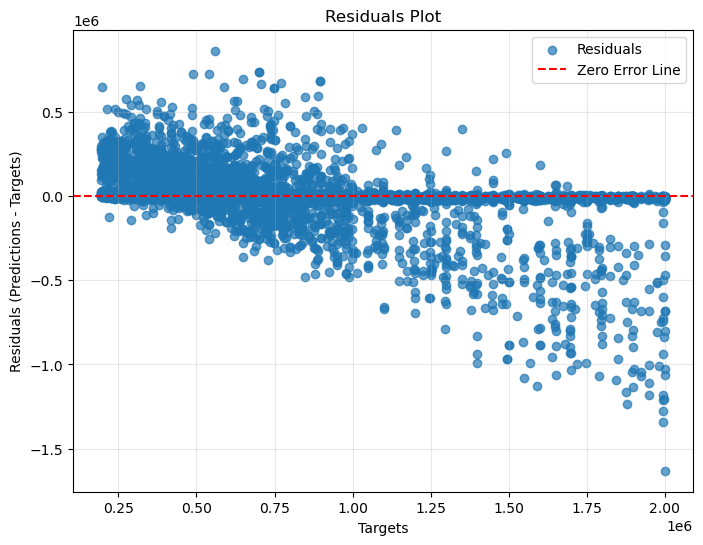

In [109]:
import matplotlib.pyplot as plt
# Calculate residuals
residuals = output - targets

# Create a residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(targets, residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')

plt.title('Residuals Plot')
plt.xlabel('Targets')
plt.ylabel('Residuals (Predictions - Targets)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [110]:
feature_importances

array([5.9814210e-04, 1.7679440e-04, 5.0029903e-05, ..., 0.0000000e+00,
       1.3135950e-03, 0.0000000e+00], dtype=float32)

In [112]:
sum = 0
for f in feature_importances:
    print(f)
    sum += f

0.0005981421
0.0001767944
5.0029903e-05
0.001426511
3.5240917e-06
2.3527912e-06
1.2414879e-06
5.987107e-06
5.348786e-07
1.0659674e-05
2.0826155e-05
1.5647594e-05
2.0038886e-05
5.1970474e-06
1.9772997e-05
6.987717e-06
3.8785424e-06
5.9834633e-06
3.912539e-06
4.3763025e-06
1.0180951e-05
4.948966e-06
1.0488068e-05
7.0792653e-06
1.0976953e-05
9.766088e-06
3.306941e-06
7.678795e-06
4.309004e-06
9.330589e-06
6.3378097e-06
2.0256959e-05
9.322162e-06
7.052543e-06
1.5216695e-05
1.20781115e-05
1.25059705e-05
1.235274e-05
2.7125921e-05
4.371532e-06
7.212561e-06
4.405885e-06
5.5079286e-06
8.7519e-06
5.3936074e-06
1.0132257e-05
3.9167604e-05
8.0192585e-05
1.5171375e-05
9.4216746e-05
5.244783e-07
5.7336993e-06
5.5738824e-06
3.5498679e-06
8.071466e-06
5.5905693e-05
1.9472527e-05
2.0006013e-05
7.2831235e-06
2.0263878e-05
5.4207603e-06
6.010933e-06
9.9594814e-05
1.09623315e-05
3.173616e-05
2.185675e-06
3.0371973e-06
1.6348346e-05
6.8173554e-06
3.6615693e-05
1.3555667e-06
9.092604e-06
7.3306123e-06
3.54

In [113]:
sum

0.9999999905717021

In [114]:
0.9999999905717021 - 0.0005981421 - 0.0001767944 - 5.0029903e-05 - 0.001426511

0.9977485131687022